In [79]:
import pandas as pd
import copy
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.interpolate import make_interp_spline
import os

In [150]:
df_copy = pd.read_csv("Wildfire_Dataset.csv")

/tmp/ipykernel_18301/3328195843.py:1: DtypeWarning: Columns (7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_copy = pd.read_csv("Wildfire_Dataset.csv")


In [151]:
df = copy.deepcopy(df_copy)
df.drop(["Unnamed: 0", "FIPS_CODE"], axis=1, inplace=True)

In [152]:
columns = {'FIRE_YEAR': "year",
       'DISCOVERY_DATE': "discovery_date", 'DISCOVERY_DOY': "discovery_doy", 'DISCOVERY_TIME': "discovery_time",
       'NWCG_CAUSE_CLASSIFICATION': "cause_class", 'NWCG_GENERAL_CAUSE': "cause_description",
       'NWCG_CAUSE_AGE_CATEGORY': "cause_age", 'CONT_DATE': "contained_date", 'CONT_DOY': "contained_doy", 'CONT_TIME': "contained_time",
       'FIRE_SIZE': "size", 'FIRE_SIZE_CLASS': "size_class", 'LATITUDE': "latitude", 'LONGITUDE': "longitude", 
       'STATE': "state", 'COUNTY': "county", 'FIPS_CODE': "fips_code", 'FIPS_NAME': "fips_name"}

df.rename(mapper= lambda column: columns[column] if column in columns.keys() else column, axis=1, inplace=True)

df["discovery_month"] = df["discovery_date"].apply(lambda date: date.split("/")[1])
df["discovery_day"] = df["discovery_date"].apply(lambda date: date.split("/")[0])


def calc_duration(series: pd.Series):
     if any(math.isnan(x) if (type(x) is not str) else False for x in [series["contained_doy"], series ["discovery_doy"], series["contained_date"], series["year"]]):
          return None
     return series["contained_doy"] - series ["discovery_doy"] + (int(series["contained_date"].split("/")[-1]) - series["year"]) * 365 + 1

df["duration"] = df.apply(func= calc_duration, axis=1)

In [153]:
df

year discovery_date  discovery_doy  discovery_time  \
0        2005       2/2/2005             33          1300.0   
1        2004      5/12/2004            133           845.0   
2        2004      5/31/2004            152          1921.0   
3        2004      6/28/2004            180          1600.0   
4        2004      6/28/2004            180          1600.0   
...       ...            ...            ...             ...   
2303561  2020       6/5/2020            157          1741.0   
2303562  2020      7/11/2020            193          1958.0   
2303563  2020      8/27/2020            240          1911.0   
2303564  2020      8/17/2020            230           755.0   
2303565  2020     11/20/2020            325          1110.0   

                                     cause_class  \
0                                          Human   
1                                        Natural   
2                                          Human   
3                                        Natural   
4                                        Natural   
...                                          ...   
2303561                                  Natural   
2303562  Missing data/not specified/undetermined   
2303563                                  Natural   
2303564                                  Natural   
2303565                                    Human   

                                  cause_description cause_age contained_date  \
0        Power generation/transmission/distribution       NaN       2/2/2005   
1                                           Natural       NaN      5/12/2004   
2                           Debris and open burning       NaN      5/31/2004   
3                                           Natural       NaN       7/3/2004   
4                                           Natural       NaN       7/3/2004   
...                                             ...       ...            ...   
2303561                                     Natural       NaN            NaN   
2303562     Missing data/not specified/undetermined       NaN            NaN   
2303563                                     Natural       NaN            NaN   
2303564                                     Natural       NaN      8/20/2020   
2303565     Missing data/not specified/undetermined       NaN     11/22/2020   

         contained_doy  contained_time      size size_class   latitude  \
0                 33.0          1730.0      0.10          A  40.036944   
1                133.0          1530.0      0.25          A  38.933056   
2                152.0          2024.0      0.10          A  38.984167   
3                185.0          1400.0      0.10          A  38.559167   
4                185.0          1200.0      0.10          A  38.559167   
...                ...             ...       ...        ...        ...   
2303561            NaN             NaN      1.00          B  39.037890   
2303562            NaN             NaN    100.00          D  37.148611   
2303563            NaN             NaN     50.00          C  46.151370   
2303564          233.0          1900.0  24892.00          G  46.670340   
2303565          327.0          1223.0    105.00          D  38.578900   

          longitude state      county          fips_name discovery_month  \
0       -121.005833    CA        63.0      Plumas County               2   
1       -120.404444    CA        61.0      Placer County              12   
2       -120.735556    CA        17.0   El Dorado County              31   
3       -119.913333    CA         3.0      Alpine County              28   
4       -119.933056    CA         3.0      Alpine County              28   
...             ...   ...         ...                ...             ...   
2303561 -108.959500    CO         NaN                NaN               5   
2303562 -119.503056    CA      Madera      Madera County              11   
2303563 -114.442800    MT         NaN                NaN              27   
2303564 -120.1145

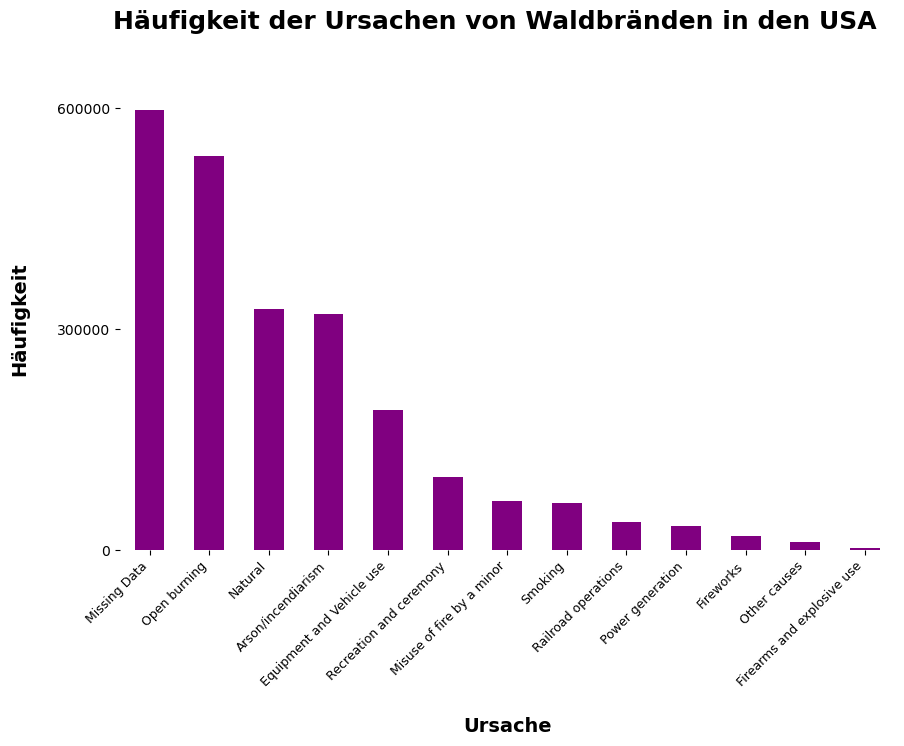

In [84]:
#Christophs Code
cause_counts = df['cause_description'].value_counts()

fig, ax = plt.subplots(figsize = (10, 6))


bars = cause_counts.plot(kind = 'bar', color = 'purple', ax = ax)
#ax.set_title('Häufigkeit der Ursachen von Waldbränden in den USA', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Ursache', fontsize = 14, fontweight = 'bold', labelpad = 20)
ax.set_ylabel('Häufigkeit', fontsize = 14, fontweight = 'bold', labelpad = 20)

new_labels = ['Missing Data', 'Open burning', 'Natural', 'Arson/incendiarism', 'Equipment and Vehicle use', 'Recreation and ceremony', 'Misuse of fire by a minor', 'Smoking', 'Railroad operations', 'Power generation', 'Fireworks', 'Other causes', 'Firearms and explosive use']
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation = 45, ha = 'right', fontsize = 9)
ax.tick_params(axis = 'y', labelsize = 9)

yticks = ax.get_yticks()
new_yticks = [yticks[0], yticks[3], yticks[-2]]  # Nur den 3. und letzten Wert nehmen
new_y_labels = [f'{int(new_yticks[0])}', f'{int(new_yticks[1])}', f'{int(new_yticks[-1])}']
ax.set_yticks(new_yticks)
ax.set_yticklabels(new_y_labels, fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.suptitle('Häufigkeit der Ursachen von Waldbränden in den USA', fontsize=18, fontweight='bold', y = 1.01, x = 0.5)

plt.show()

/tmp/ipykernel_53870/4282119983.py:4: DtypeWarning: Columns (7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Wildfire_Dataset.csv")
/tmp/ipykernel_53870/4282119983.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cause_counts_selected['Others'] = cause_counts_per_year.drop(columns=selected_categories).sum(axis=1)
/tmp/ipykernel_53870/4282119983.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cause_counts_selected["Natural_percent"] = cause_co

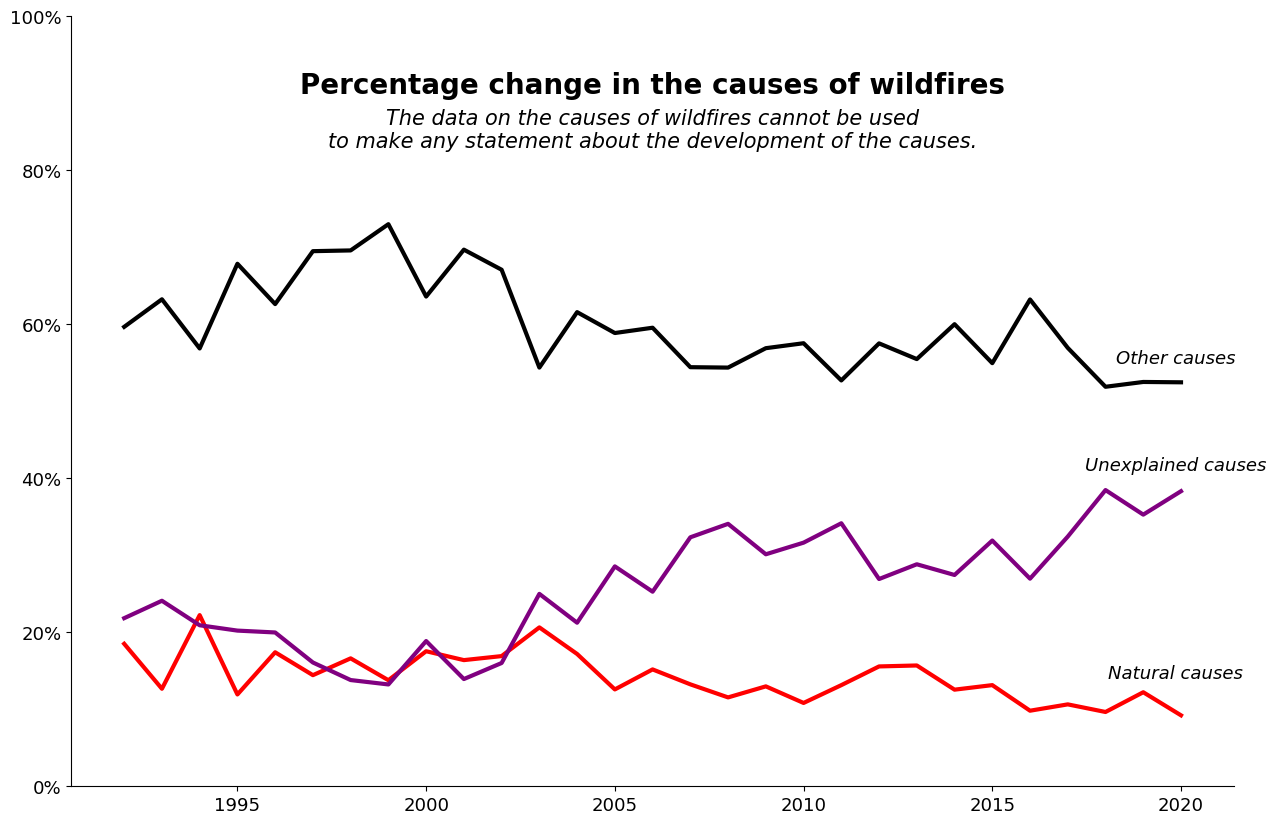

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Wildfire_Dataset.csv")

df = df.rename(columns={
    'FIRE_YEAR': 'year', 'DISCOVERY_DATE': 'discovery_date', 'DISCOVERY_DOY': 'discovery_doy', 
    'DISCOVERY_TIME': 'discovery_time', 'NWCG_CAUSE_CLASSIFICATION': 'cause_class', 
    'NWCG_GENERAL_CAUSE': 'cause_description', 'NWCG_CAUSE_AGE_CATEGORY': 'cause_age', 
    'CONT_DATE': 'contained_date', 'CONT_DOY': 'contained_doy', 'CONT_TIME': 'contained_time', 
    'FIRE_SIZE': 'size', 'FIRE_SIZE_CLASS': 'size_class', 'LATITUDE': 'latitude', 
    'LONGITUDE': 'longitude', 'STATE': 'state', 'COUNTY': 'county', 'FIPS_CODE': 'fips_code', 
    'FIPS_NAME': 'fips_name'
})

df["discovery_date"] = pd.to_datetime(df["discovery_date"])
df["year"] = df["discovery_date"].dt.year

cause_counts_per_year = df.groupby(['year', 'cause_description']).size().unstack(fill_value=0)

selected_categories = ['Natural', 'Missing data/not specified/undetermined']
cause_counts_selected = cause_counts_per_year[selected_categories]
cause_counts_selected['Others'] = cause_counts_per_year.drop(columns=selected_categories).sum(axis=1)

cause_counts_selected["Natural_percent"] = cause_counts_selected.apply(lambda series: series["Natural"]/sum(series[["Natural", "Missing data/not specified/undetermined", "Others"]]), axis=1)
cause_counts_selected["Missing_percent"] = cause_counts_selected.apply(lambda series: series["Missing data/not specified/undetermined"]/sum(series[["Natural", "Missing data/not specified/undetermined", "Others"]]), axis=1)
cause_counts_selected["Others_percent"] = cause_counts_selected.apply(lambda series: series["Others"]/sum(series[["Natural", "Missing data/not specified/undetermined", "Others"]]), axis=1)

colors = ['red', 'purple', 'black']

fig, ax = plt.subplots(figsize=(15, 10))

ax.tick_params(axis='both', which='major', labelsize=13)

ax.set_yticks(np.linspace(0, 1.0, 6))
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize = 13)

ax.annotate('Percentage change in the causes of wildfires', xy=(0.5, 0.9), xycoords='axes fraction', ha='center', color='black', fontweight='bold', fontsize=20)
ax.annotate('The data on the causes of wildfires cannot be used\nto make any statement about the development of the causes.', xy=(0.5, 0.83), xycoords='axes fraction', ha='center', color='black', fontstyle='italic', fontsize=15)
ax.annotate('Other causes', xy=(0.95, 0.55), xycoords='axes fraction', ha='center', color='black', fontsize=13, fontstyle='italic')
ax.annotate('Unexplained causes', xy=(0.95, 0.41), xycoords='axes fraction', ha='center', color='black', fontsize=13, fontstyle='italic')
ax.annotate('Natural causes', xy=(0.95, 0.14), xycoords='axes fraction', ha='center', color='black', fontsize=13, fontstyle='italic')

cause_counts_selected[["Natural_percent", "Missing_percent", "Others_percent"]].plot(kind='line', ax=ax, color = colors, legend=False, linewidth = 3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylim(0, 1)
ax.set_xlabel('')
plt.show()

/tmp/ipykernel_53870/3494823973.py:6: DtypeWarning: Columns (7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Wildfire_Dataset.csv")
/tmp/ipykernel_53870/3494823973.py:39: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  filtered_gdf1.plot(ax=ax, column='size_class', markersize=filtered_gdf1['size'] / 500, legend=False, color=[colors[x] for x in filtered_gdf1['size_class']])


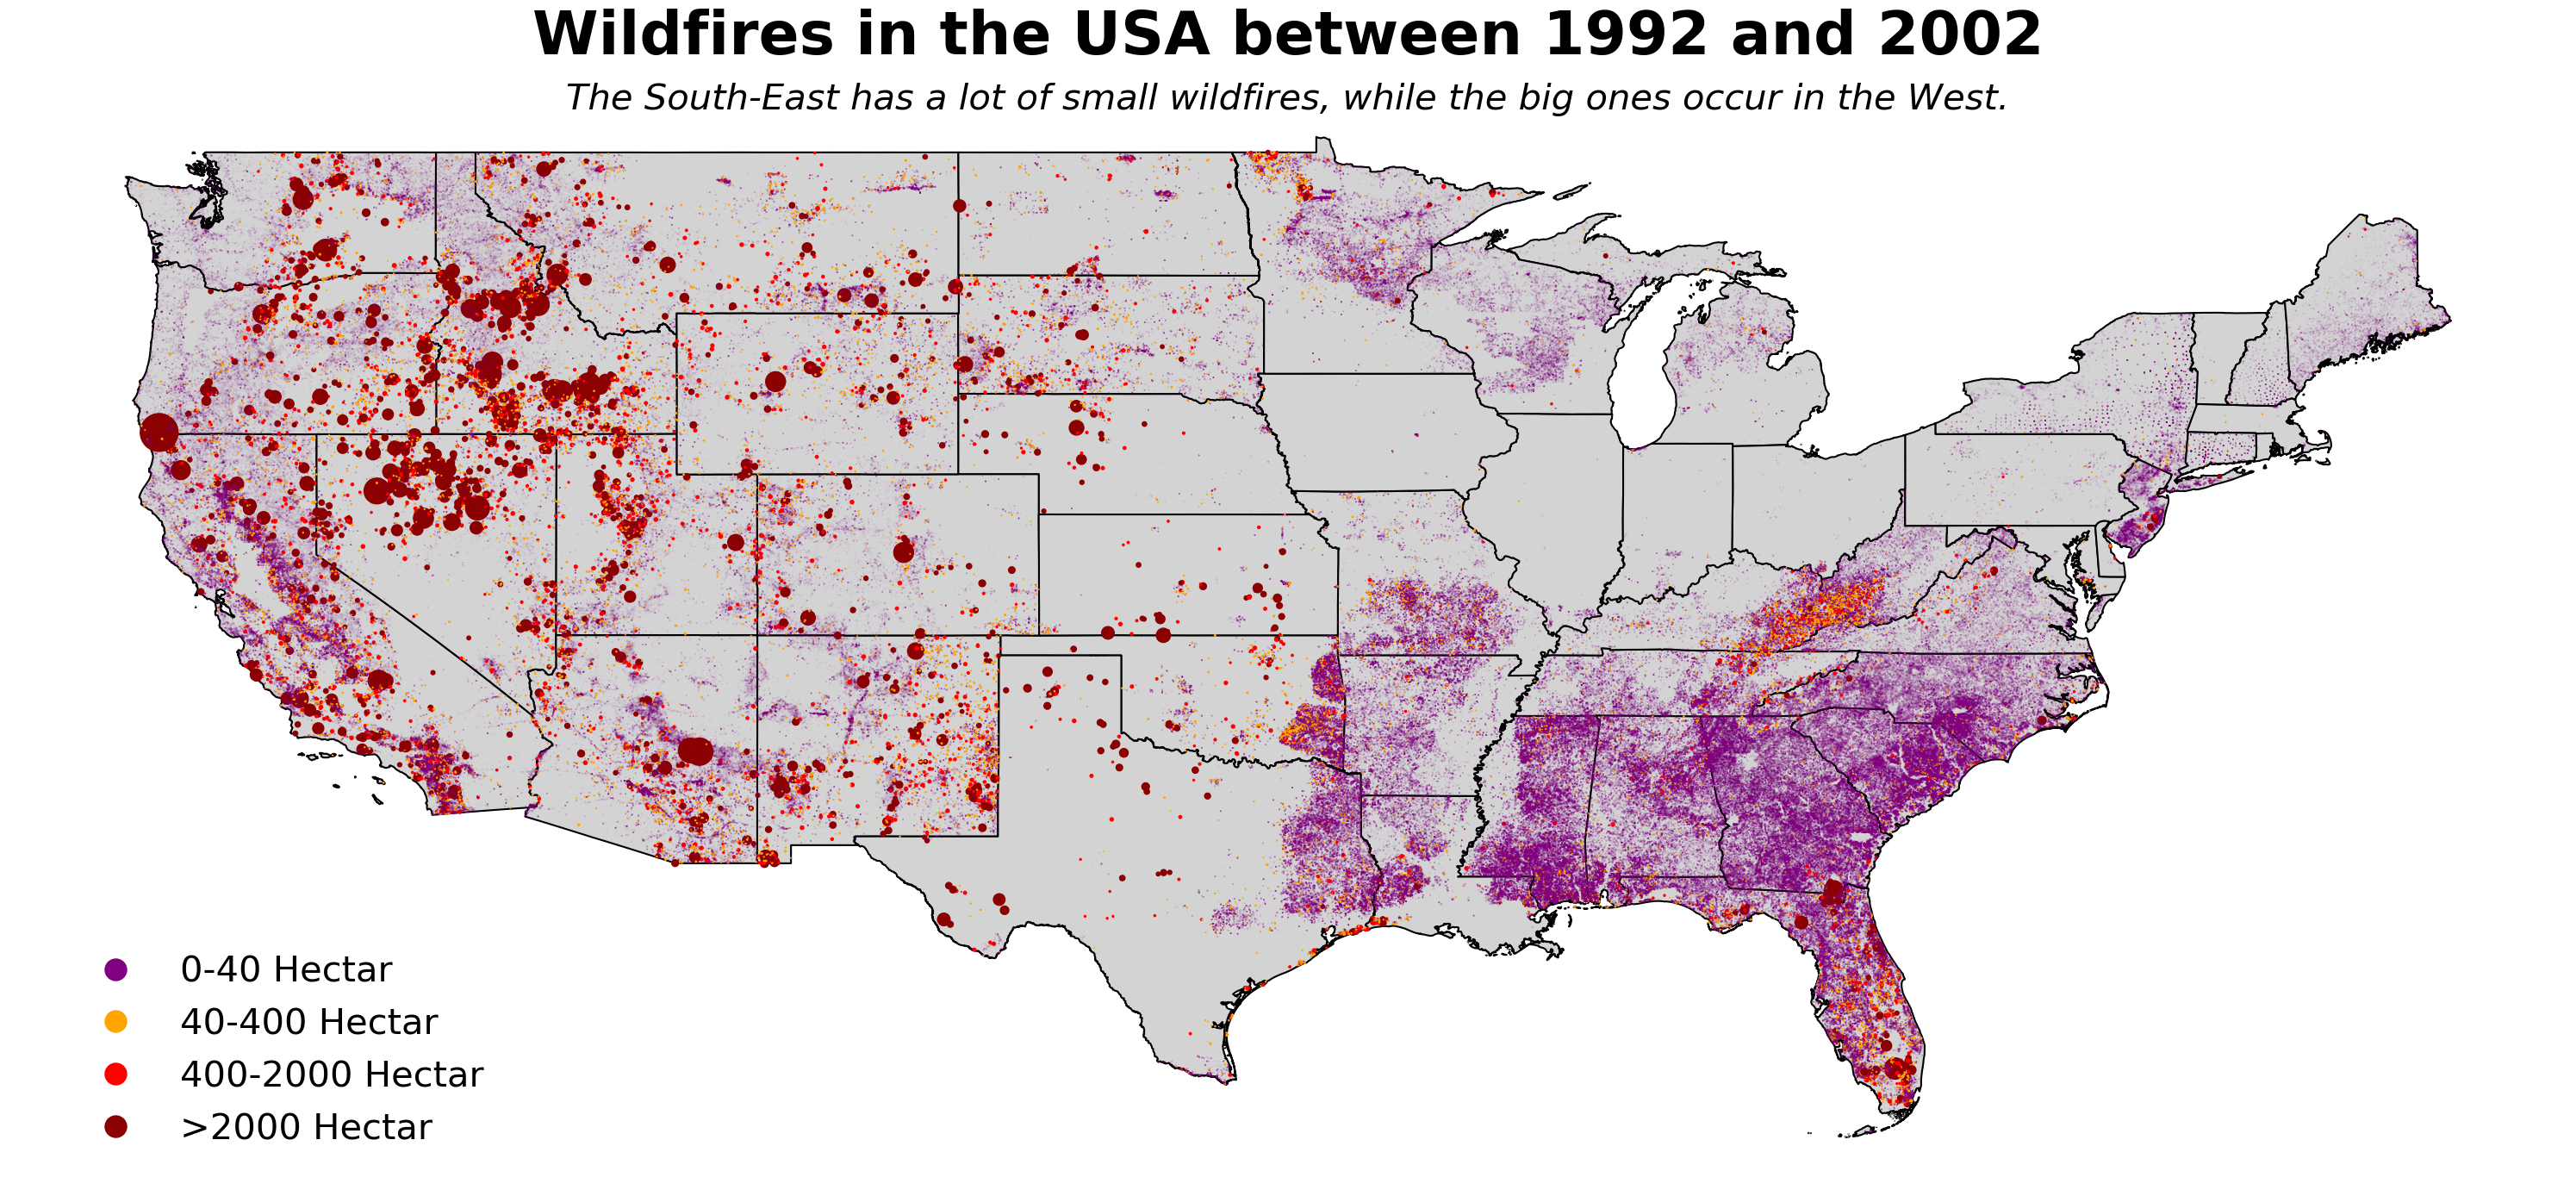

In [74]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv("Wildfire_Dataset.csv")
df = df.rename(columns={
    'FIRE_YEAR': 'year', 'DISCOVERY_DATE': 'discovery_date', 'DISCOVERY_DOY': 'discovery_doy', 
    'DISCOVERY_TIME': 'discovery_time', 'NWCG_CAUSE_CLASSIFICATION': 'cause_class', 
    'NWCG_GENERAL_CAUSE': 'cause_description', 'NWCG_CAUSE_AGE_CATEGORY': 'cause_age', 
    'CONT_DATE': 'contained_date', 'CONT_DOY': 'contained_doy', 'CONT_TIME': 'contained_time', 
    'FIRE_SIZE': 'size', 'FIRE_SIZE_CLASS': 'size_class', 'LATITUDE': 'latitude', 
    'LONGITUDE': 'longitude', 'STATE': 'state', 'COUNTY': 'county', 'FIPS_CODE': 'fips_code', 
    'FIPS_NAME': 'fips_name'
})

df["discovery_date"] = pd.to_datetime(df["discovery_date"])
df["contained_date"] = pd.to_datetime(df["contained_date"])
df["duration"] = (df["contained_date"] - df["discovery_date"]).dt.days + 1

shape_path = 'Shapefiles/cb_2018_us_state_500k.shp'
usa = gpd.read_file(shape_path)
continental_us_bounds = {"minx": -125, "miny": 24, "maxx": -66, "maxy": 50}
usa = usa.cx[continental_us_bounds["minx"]:continental_us_bounds["maxx"], continental_us_bounds["miny"]:continental_us_bounds["maxy"]]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

interval1 = (pd.Timestamp('1992-01-01'), pd.Timestamp('2002-12-31'))

filtered_gdf1 = gdf[(gdf['discovery_date'].between(*interval1))]

filtered_gdf1 = filtered_gdf1.cx[continental_us_bounds["minx"]:continental_us_bounds["maxx"], continental_us_bounds["miny"]:continental_us_bounds["maxy"]]

fig, ax = plt.subplots(figsize=(30, 30))

colors = {'A': 'purple', 'B': 'purple', 'C': 'purple', 'D': 'orange', 'E': 'orange', 'F': 'red', 'G': 'darkred'}

usa.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1.5)
filtered_gdf1.plot(ax=ax, column='size_class', markersize=filtered_gdf1['size'] / 500, legend=False, color=[colors[x] for x in filtered_gdf1['size_class']])
ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.annotate('Wildfires in the USA between 1992 and 2002', xy=(0.5, 1.03), xycoords='axes fraction', ha='center', color='black', fontweight='bold', fontsize=50)
ax.annotate('The South-East has a lot of small wildfires, while the big ones occur in the West.', xy=(0.5, 0.98), xycoords='axes fraction', ha='center', color='black', fontsize=30, fontstyle='italic')

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='0-40 Hectar', markerfacecolor='purple', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='40-400 Hectar', markerfacecolor='orange', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='400-2000 Hectar', markerfacecolor='red', markersize=20),
    Line2D([0], [0], marker='o', color='w', label='>2000 Hectar', markerfacecolor='darkred', markersize=20)
]

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.02, 0.34), fontsize=30, frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_53870/1355550123.py:6: DtypeWarning: Columns (7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Wildfire_Dataset.csv")
/tmp/ipykernel_53870/1355550123.py:39: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  filtered_gdf2.plot(ax=ax, column='size_class', markersize=filtered_gdf2['size'] / 500, legend=False, color=[colors[x] for x in filtered_gdf2['size_class']])


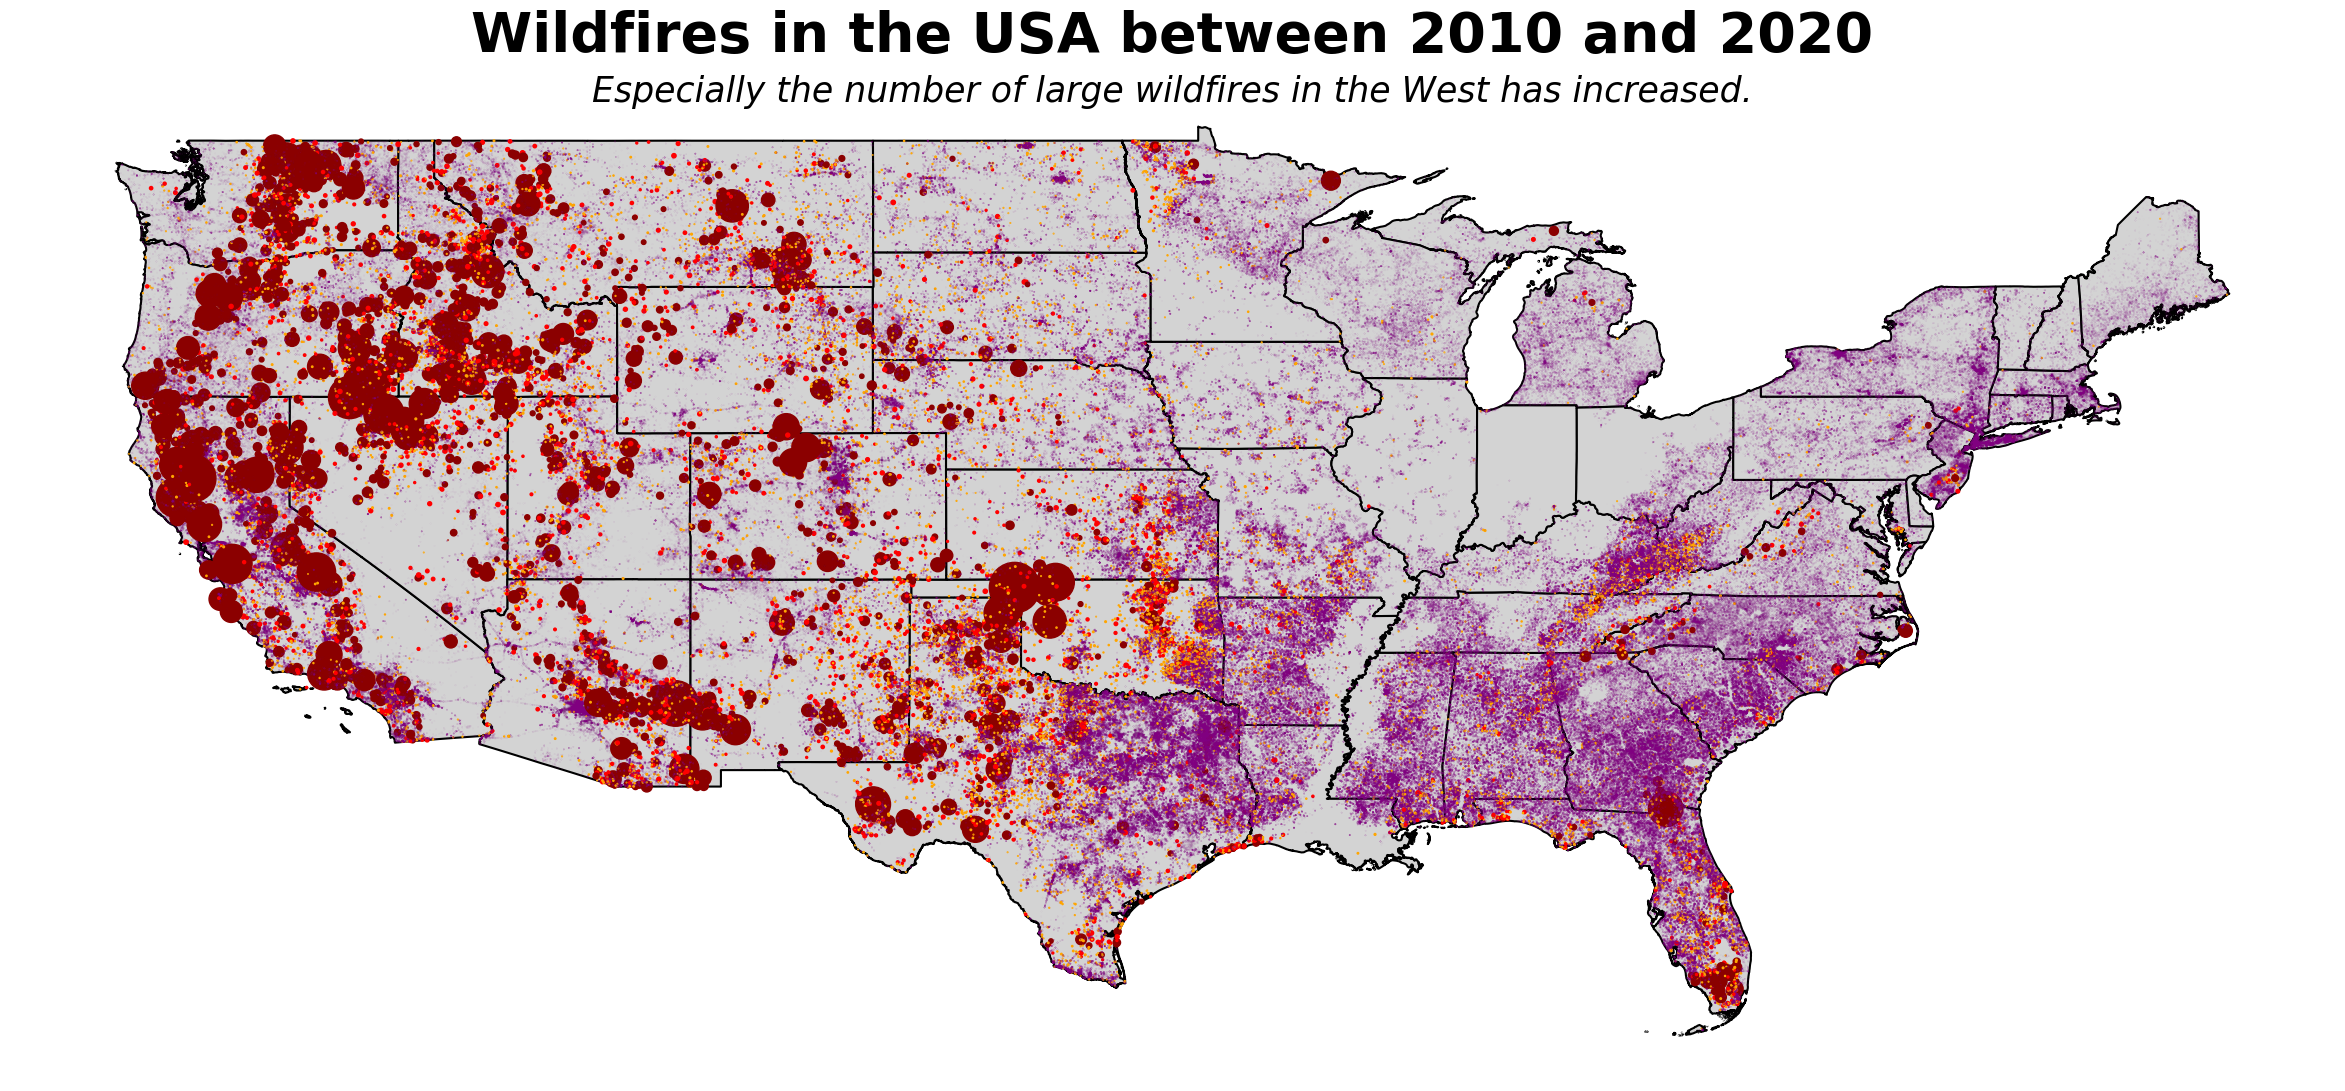

In [77]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = pd.read_csv("Wildfire_Dataset.csv")
df = df.rename(columns={
    'FIRE_YEAR': 'year', 'DISCOVERY_DATE': 'discovery_date', 'DISCOVERY_DOY': 'discovery_doy', 
    'DISCOVERY_TIME': 'discovery_time', 'NWCG_CAUSE_CLASSIFICATION': 'cause_class', 
    'NWCG_GENERAL_CAUSE': 'cause_description', 'NWCG_CAUSE_AGE_CATEGORY': 'cause_age', 
    'CONT_DATE': 'contained_date', 'CONT_DOY': 'contained_doy', 'CONT_TIME': 'contained_time', 
    'FIRE_SIZE': 'size', 'FIRE_SIZE_CLASS': 'size_class', 'LATITUDE': 'latitude', 
    'LONGITUDE': 'longitude', 'STATE': 'state', 'COUNTY': 'county', 'FIPS_CODE': 'fips_code', 
    'FIPS_NAME': 'fips_name'
})

df["discovery_date"] = pd.to_datetime(df["discovery_date"])
df["contained_date"] = pd.to_datetime(df["contained_date"])
df["duration"] = (df["contained_date"] - df["discovery_date"]).dt.days + 1

shape_path = 'Shapefiles/cb_2018_us_state_500k.shp'
usa = gpd.read_file(shape_path)
continental_us_bounds = {"minx": -125, "miny": 24, "maxx": -66, "maxy": 50}
usa = usa.cx[continental_us_bounds["minx"]:continental_us_bounds["maxx"], continental_us_bounds["miny"]:continental_us_bounds["maxy"]]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

interval2 = (pd.Timestamp('2010-01-01'), pd.Timestamp('2020-12-31'))

filtered_gdf2 = gdf[(gdf['discovery_date'].between(*interval2))]

filtered_gdf2 = filtered_gdf2.cx[continental_us_bounds["minx"]:continental_us_bounds["maxx"], continental_us_bounds["miny"]:continental_us_bounds["maxy"]]

fig, ax = plt.subplots(figsize=(30, 30))

colors = {'A': 'purple', 'B': 'purple', 'C': 'purple', 'D': 'orange', 'E': 'orange', 'F': 'red', 'G': 'darkred'}

usa.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1.5)
filtered_gdf2.plot(ax=ax, column='size_class', markersize=filtered_gdf2['size'] / 500, legend=False, color=[colors[x] for x in filtered_gdf2['size_class']])
ax.set_xticks([])
ax.set_yticks([])

ax.annotate('Wildfires in the USA between 2010 and 2020', xy=(0.5, 1.03), xycoords='axes fraction', ha='center', color='black', fontweight='bold', fontsize=40)
ax.annotate('Especially the number of large wildfires in the West has increased.', xy=(0.5, 0.98), xycoords='axes fraction', ha='center', color='black', fontsize=25, fontstyle='italic')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()